In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import math
import numpy as np
from gp import gaussian_process
from MCMC import MetropolisHastings
from sampler import lhs_sampler
from kernel import kernel_rbf
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt


class koh:
    def __init__(
        self, dim_x: int, m_num: int, u, random_walk: list, sample_nums: int = 10000
    ):
        super(koh, self).__init__()
        self.JITTER = 1e-6
        self.dtype = torch.float64

        self.dim_x = dim_x
        self.dim_u = len(u)

        self.m_xu = None
        self.m_y = None
        self.m_gp = gaussian_process(dim_x + self.dim_u)
        self.m_sampler = lhs_sampler(m_num, dim_x + self.dim_u)

        self.f_x = None
        self.f_y = None
        self.b_y = None
        self.u = torch.tensor(u, dtype=self.dtype).view(-1)
        self.b_gp = gaussian_process(dim_x)

        self.cov_m = None
        self.cov_b = None
        self.random_walk = random_walk
        self.mcmc = MetropolisHastings(sample_nums=sample_nums, random_walk=random_walk)
        self.sample = None

    def sigma_m(self, x, y, noise=False):
        if noise:
            return self.m_gp.kernel_noise(x, y)
        else:
            return self.m_gp.kernel(x, y)

    def sigma_b(
        self,
        x,
        y,
    ):
        return self.b_gp.kernel_noise(x, y)

    def negative_log_likelihood(self, u) -> float:
        u = torch.tensor(u)
        xfu = torch.hstack((self.f_x, torch.ones((self.f_x.shape[0], len(u))) * u))
        cov_mf = self.sigma_m(self.m_xu, xfu)
        cov_f = self.sigma_m(xfu, xfu) + self.cov_b

        cov = torch.cat(
            (
                torch.cat((self.cov_m, cov_mf), dim=1),
                torch.cat((cov_mf.transpose(0, 1), cov_f), dim=1),
            ),
            dim=0,
        )
        cov = cov + self.JITTER * torch.eye(cov.shape[0])
        L = torch.linalg.cholesky(cov)  # upper=False(defate)
        # option 1 (use this if torch supports)
        gamma = torch.linalg.solve_triangular(L, self.y, upper=False)
        nll = -0.5 * (gamma**2).sum() - L.diag().log().sum()
        return nll

    def log_parameter_prior(
        self, u, mean=[0.0, 0.0], cov=[[1, 0], [0, 1]], lwr=[-0.5, -0.5], upr=[1.5, 1.5]
    ) -> float:

        for i in range(self.dim_u):
            if u[i] < lwr[i]:
                return -math.inf
            if u[i] > upr[i]:
                return -math.inf
        dist = multivariate_normal(mean=mean, cov=cov)
        return dist.logpdf(u)

    def ym_train(self, ym):
        self.m_xu = torch.tensor(
            self.m_sampler.sampling(), dtype=self.dtype, requires_grad=False
        )
        m_x = self.m_xu[:, 0 : self.dim_x]
        m_u = self.m_xu[:, self.dim_x :]
        self.m_y = ym(m_x, m_u)
        self.m_gp.train_adam(self.m_xu, self.m_y)

    def yb_train(self, f_x, f_y):
        self.f_x = f_x
        f_xu = torch.cat((f_x, torch.ones((f_x.shape[0], len(self.u))) * self.u), 1)
        self.f_y = f_y
        m_ypred, m_yvar = self.m_gp(f_xu)
        self.b_y = f_y - m_ypred
        self.b_gp.train_adam(f_x, self.b_y)

    def parameter_mcmc(self):
        u = self.u.numpy()
        self.cov_m = self.sigma_m(self.m_xu, self.m_xu)
        self.cov_b = self.sigma_b(self.f_x, self.f_x)
        self.y = torch.vstack((self.m_y, self.f_y))
        self.sample = self.mcmc.sampling(
            u,
            self.log_parameter_prior,
            self.negative_log_likelihood,
        )

    def forward(self, ym, f_x, f_y, u):
        self.ym_train(ym)
        self.yb_train(f_x, f_y)
        return self.parameter_mcmc(u)

    def set_random_walk(self, random_walk):
        self.random_walk = random_walk

    def set_m_hyperparameter(self, log_length_scale, log_scale, log_beta):
        self.m_gp.set_hyperparameter(log_length_scale, log_scale, log_beta)

    def set_b_hyperparameter(self, log_length_scale, log_scale, log_beta):
        self.b_gp.set_hyperparameter(log_length_scale, log_scale, log_beta)

    def get_m_hyperparameter(self):
        return self.m_gp.get_hyperparameter()

    def get_b_hyperparameter(self):
        return self.b_gp.get_hyperparameter()

    def set_u(self, u):
        self.u = torch.tensor(u, dtype=self.dtype).view(-1)

    def plot_sample(self):
        # for i in range(self.dim_u):
        #     elements = self.sample[:, i]
        #     plt.scatter(range(0, self.mcmc.iter), elements)
        #     plt.show()
        first_elements = self.sample[:, 0]
        second_elements = self.sample[:, 1]
        plt.scatter(first_elements, second_elements)
        plt.show()



In [9]:

def ym(x, u):
    y = (
        0.3
        + 0.5 * torch.sin(x[:, 0] * u[:, 0] * 3 * math.pi)
        + u[:, 1] * (x[:, 1] ** 3)
    )
    return y.reshape(-1, 1)

koh1 = koh(2, 100, [0.1, 0.1], [[0.5, 0], [0, 0.5]])
koh1.ym_train(ym)



nnl:8.103468662 likelihood:0.000302488
 log_length_scale:[-0.5681022494928658]
 log_scale:-0.9310597042767643
 log_beta:5.83232776483796


In [10]:
def yf(x, mean=0, std=0.01):
    y = (
        0.3
        + 0.5 * torch.sin(x[:, 0] * math.pi)
        + 0.7 * (x[:, 1] ** 3)
        + std * torch.randn(x.shape[0])
        + mean
    )
    return y.reshape(-1, 1)

f_x = torch.torch.rand(40, 2, requires_grad=False)
f_y = yf(f_x)

koh1.yb_train(f_x, f_y)


nnl:-82.138875472 likelihood:470392476842453002177937904504930304.000000000
 log_length_scale:[-0.21703630661435208]
 log_scale:-0.7973717327690768
 log_beta:9.41926500615584


In [11]:
koh1.parameter_mcmc()

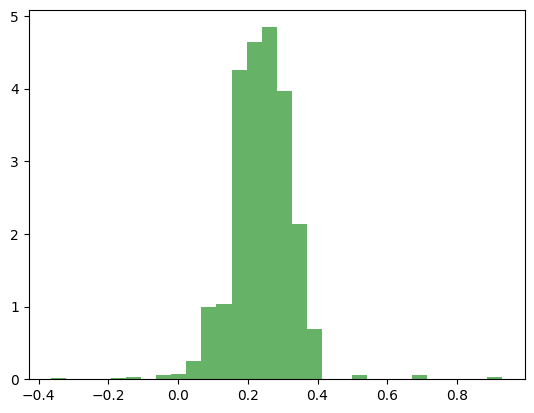

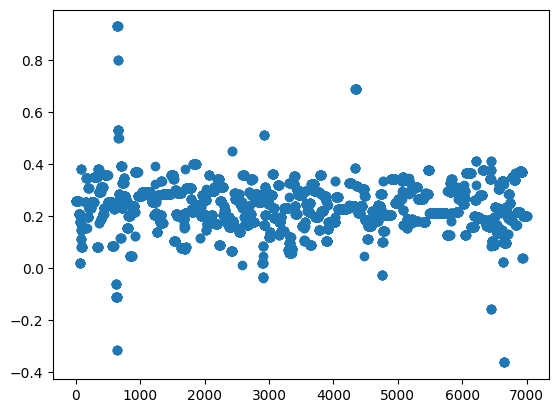

In [12]:
first_elements = [row[0] for row in koh1.sample]

plt.hist(first_elements, bins=30, density=True, alpha=0.6, color="g")
plt.show()
plt.scatter(range(0,len(first_elements)), first_elements)
plt.show()


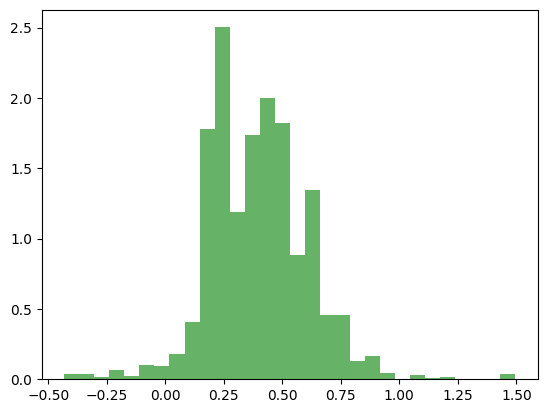

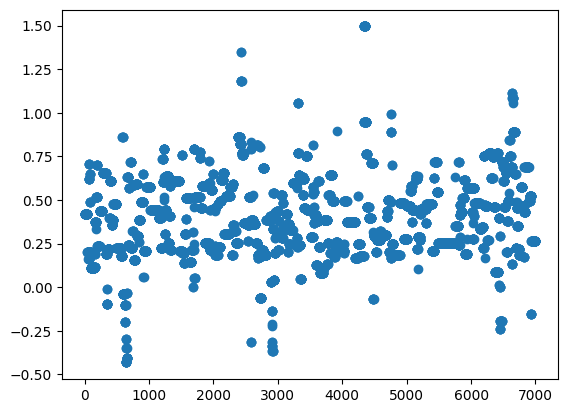

0.23919833669802815 0.3957392573574657


In [13]:
second_elements = [row[1] for row in koh1.sample]
plt.hist(second_elements, bins=30, density=True, alpha=0.6, color="g")
plt.show()
plt.scatter(range(0,len(second_elements)), second_elements)
plt.show()
print(np.mean(first_elements), np.mean(second_elements))